In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터 불러오기, 공통 전처리

In [4]:
raw_data = pd.read_csv('C:/Users/sjkan/Desktop/newdata4.csv', encoding = 'cp949')
raw_data = raw_data[:-1]

# 컬럼 버리기
raw_data = raw_data.drop(raw_data[['대곡교_강수량','진관교_강수량','송정동_강수량','서울시_강수량']], axis = 1)
#raw_data = raw_data.drop(raw_data[['대곡교_강수량','진관교_강수량','송정동_강수량','서울시_강수량']], axis = 1)


# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,,,
2012-05-01 00:00:00,0.058462,0.191781,0.022711,0.147596,0.011070,0.049611,0.060000,0.051621,0.056478,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,0.058447,0.199253,0.025623,0.147654,0.011070,0.053502,0.060000,0.051621,0.056478,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,0.057689,0.209215,0.024887,0.147478,0.011070,0.052529,0.061111,0.051621,0.056478,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,0.058462,0.219178,0.023431,0.147478,0.011475,0.050584,0.061111,0.051621,0.058140,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,0.058451,0.232877,0.023431,0.146810,0.011883,0.050584,0.061111,0.052821,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.046624,0.458281,0.007701,0.106425,0.025719,0.027529,0.054222,0.062425,0.107475,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,0.046621,0.488169,0.007114,0.097370,0.026815,0.026556,0.063111,0.068427,0.110797,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,0.046620,0.515567,0.014512,0.092994,0.027929,0.038230,0.067556,0.074430,0.114120,299.0,307.0,309.0,310.0


## train / test data 생성

In [5]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:33<00:00,  8.47s/it]


In [6]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
#ytest = ydata_[-6912:]

ytest_list = sorted(glob("C:/Users/sjkan/Desktop/submission 임시/*.csv"))
ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T

In [7]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(269358, 6, 9)
(269358, 4)
(6912, 6, 9)
(6912, 4)


## 모델 정의

In [29]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def nse(y_true, y_pred):
    return (1-(K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)))


if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(BatchNormalization(momentum=0.99, scale=False, center=False))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 6, 64)             1216      
                                                                 
 flatten_3 (Flatten)         (None, 384)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 384)           0         
 or)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 1, 200)            468000    
                                                                 
 lstm_13 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_14 (LSTM)              (None, 1, 200)            320800    
                                                      

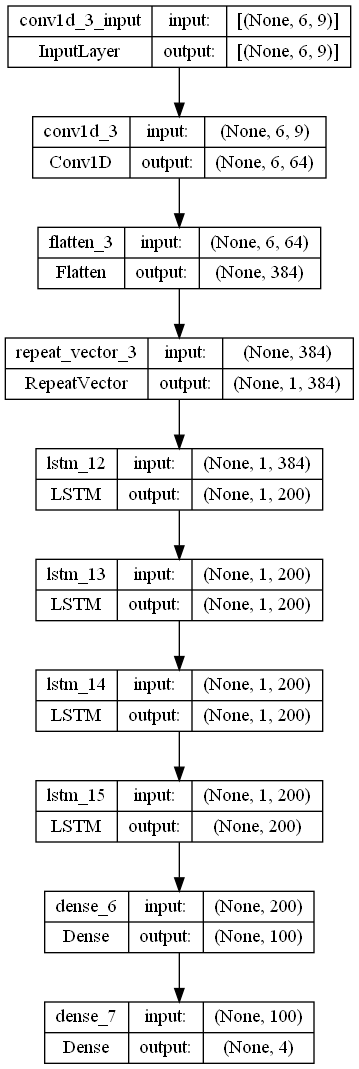

In [30]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [31]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

## 학습

In [32]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 24s 25ms/step - loss: 28.1581 - nse: -0.2459 - val_loss: 17.9146 - val_nse: 0.1733 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 21s 26ms/step - loss: 8.7484 - nse: 0.9701 - val_loss: 13.2863 - val_nse: 0.5937 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 20s 24ms/step - loss: 6.1678 - nse: 0.9852 - val_loss: 12.3005 - val_nse: 0.6460 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 24s 30ms/step - loss: 5.0273 - nse: 0.9904 - val_loss: 6.6458 - val_nse: 0.8742 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 23s 28ms/step - loss: 5.4136 - nse: 0.9888 - val_loss: 7.5396 - val_nse: 0.8475 - lr: 0.0100
Epoch 6/100
802/802 [==============================] - 24s 30ms/step - loss: 5.9297 - nse: 0.9875 - val_loss: 6.8039 - val_nse: 0.8772 - lr: 0.0100
Epoch 7/100
802/802 [==============================] - 22s 28ms/step - loss: 4.9159 - nse: 0.9911 - val_los

802/802 [==============================] - 23s 29ms/step - loss: 1.1150 - nse: 0.9996 - val_loss: 1.6222 - val_nse: 0.9925 - lr: 0.0010
Epoch 57/100
802/802 [==============================] - 25s 31ms/step - loss: 1.1143 - nse: 0.9996 - val_loss: 1.6014 - val_nse: 0.9926 - lr: 0.0010
Epoch 58/100
802/802 [==============================] - 23s 28ms/step - loss: 1.1084 - nse: 0.9996 - val_loss: 1.7246 - val_nse: 0.9921 - lr: 0.0010
Epoch 59/100
802/802 [==============================] - 23s 29ms/step - loss: 1.1082 - nse: 0.9996 - val_loss: 1.9092 - val_nse: 0.9902 - lr: 0.0010
Epoch 60/100
802/802 [==============================] - 23s 29ms/step - loss: 1.1117 - nse: 0.9996 - val_loss: 1.9558 - val_nse: 0.9914 - lr: 0.0010
Epoch 61/100
802/802 [==============================] - 26s 32ms/step - loss: 1.1150 - nse: 0.9996 - val_loss: 1.6430 - val_nse: 0.9932 - lr: 0.0010


## 평가

In [34]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 2s 7ms/step - loss: 1.2541 - nse: 0.9879


[1.2540857791900635, 0.9878970980644226]

## 학습 과정 시각화

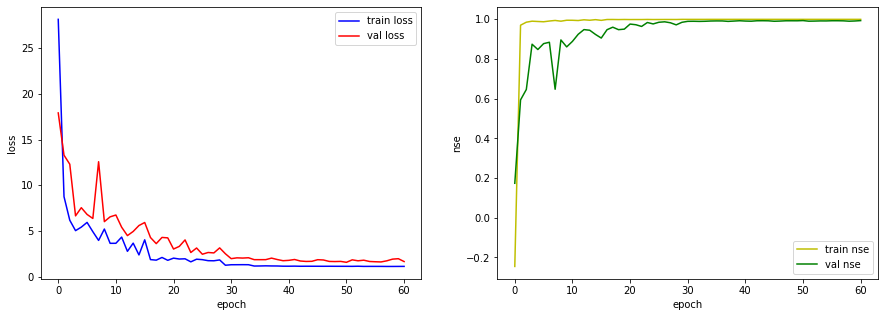

In [37]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

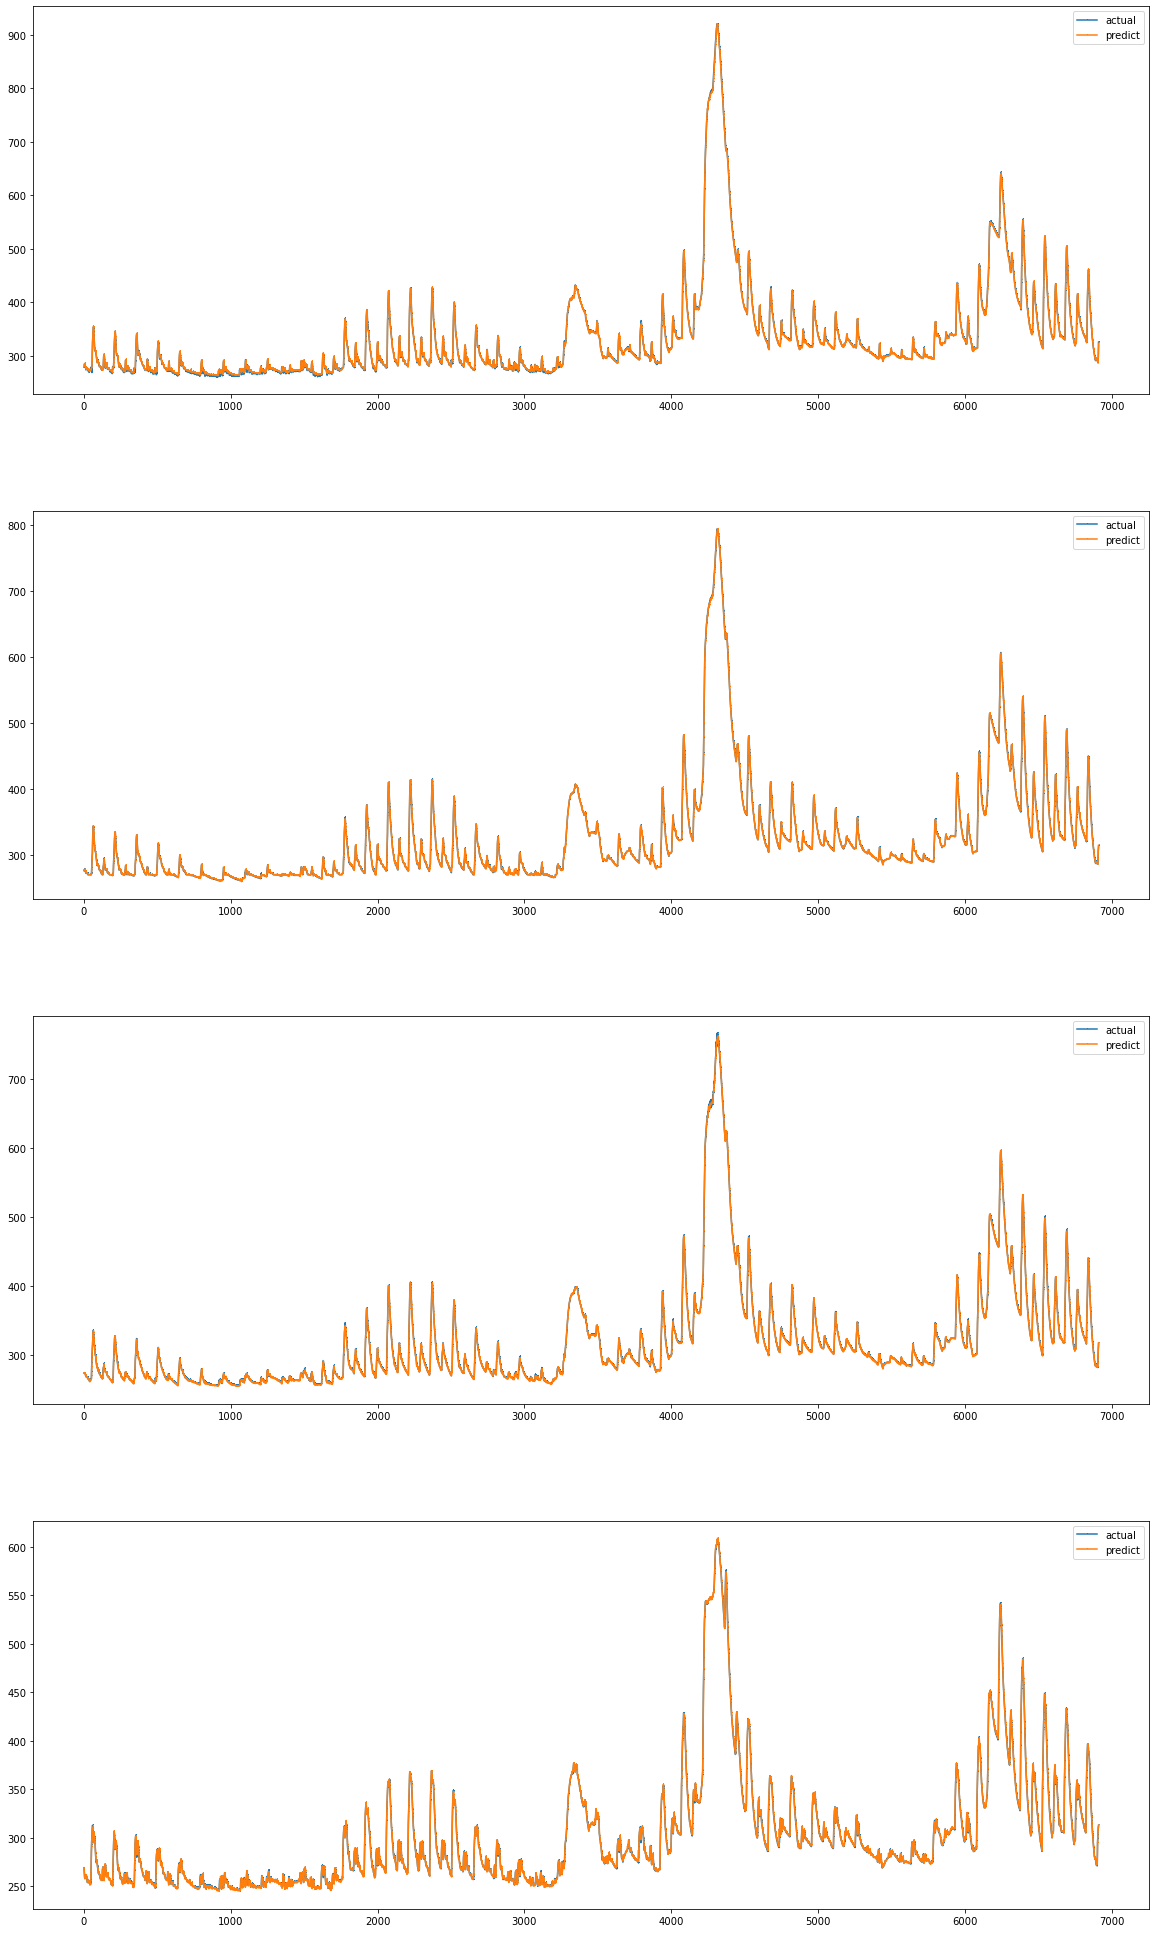

In [38]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

## 점수 확인

In [39]:
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(1.7156149722045748, shape=(), dtype=float64)
tf.Tensor(0.9020609079264809, shape=(), dtype=float64)
tf.Tensor(1.3105236075146776, shape=(), dtype=float64)
tf.Tensor(1.366623078148693, shape=(), dtype=float64)
최종점수:  1.3237056414486066


## 점수 확인

In [40]:
sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("0825 논문대로 1.32.csv", index = False)